# CS5500 : Reinforcement Learning

# Assignment № 4



# Gantasala Naga Aneesh Ajaroy

# CS19BTECH11010

## Problem 3 : Policy Gradient

## Cartpole-v0 Environment

### Import Required  Libraries

In [1]:
import gym
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from matplotlib.colors import ListedColormap
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# 3a)

## Printing State and Action Spaces

In [2]:
def load_env(name):
    env = gym.make(name)
    print("The environment {} is created".format(name))
    
    Observation_Space = env.observation_space
    Action_Space = env.action_space
    
    print("The Observation Space : {}".format(Observation_Space))
    states = Observation_Space.shape
    print("Number of Observations or Dimensions in State : {}".format(states))
    print("The First dimension represents Cart Position")
    print("The Second dimension represents Cart Velocity")
    print("The Third dimension represents Pole Angle")
    print("The Fourth dimension represents Pole Angular Velocity")
    print("Box represents a continuous ndarray")
    Upper = Observation_Space.high
    Lower = Observation_Space.low
    print("Cart Position is bounded by [{0:8.5f},{1:8.5f}]".format(Lower[0],Upper[0]))
    print("Cart Velocity is bounded by [-inf,inf]")
    print("Pole Angle is bounded by [{0:8.5f},{1:8.5f}]".format(Lower[2],Upper[2]))
    print("Pole Angular Velocity is bounded by [-inf,inf]")
    
    print("The Action Space : {}".format(Action_Space))
    actions = Action_Space.n
    print("Number of valid Actions : {}".format(actions))
    print("The discrete Deterministic actions are 0,1 ")
    print("0 -> Pust Cart to left")
    print("1 -> Pust Cart to Right")
    return env
    

In [3]:
Environment = load_env("CartPole-v0")

The environment CartPole-v0 is created
The Observation Space : Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Number of Observations or Dimensions in State : (4,)
The First dimension represents Cart Position
The Second dimension represents Cart Velocity
The Third dimension represents Pole Angle
The Fourth dimension represents Pole Angular Velocity
Box represents a continuous ndarray
Cart Position is bounded by [-4.80000, 4.80000]
Cart Velocity is bounded by [-inf,inf]
Pole Angle is bounded by [-0.41888, 0.41888]
Pole Angular Velocity is bounded by [-inf,inf]
The Action Space : Discrete(2)
Number of valid Actions : 2
The discrete Deterministic actions are 0,1 
0 -> Pust Cart to left
1 -> Pust Cart to Right


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futu

## Plotting Reward function with Random Agent

In [4]:
def reward_plot(env):
    Reward = []
    position = []
    velocity = []
    Action = []
    Angle = []
    Ang_Velocity = []
    for ep in range(1000):
        env.reset()
        while True:
            num_actions = env.action_space.n
            action_space = list(range(num_actions))
            A = random.sample(action_space,1)
            observation, reward, terminated,_ = env.step(A[0])
            Action.append(A[0])
            Reward.append(reward)
            position.append(observation[0])
            velocity.append(observation[1])
            Angle.append(observation[2])
            Ang_Velocity.append(observation[3])
            if terminated:
                break
                
    plt.subplots(figsize=(55,10))
    
    plt.subplot(1, 5, 1)
    plt.plot(position, Reward, 'r')
    plt.xlabel('position')
    plt.ylabel('reward')

    plt.subplot(1, 5, 2)
    plt.plot(velocity, Reward, 'g')
    plt.xlabel('velocity')
    plt.ylabel('reward')
    
    plt.subplot(1, 5, 3)
    plt.plot(Angle, Reward, c = 'b')
    plt.xlabel('Angle')
    plt.ylabel('reward')
    
    plt.subplot(1, 5, 4)
    plt.plot(Ang_Velocity, Reward, c = 'y')
    plt.xlabel('Ang_Velocity')
    plt.ylabel('reward')
    
    plt.subplot(1, 5, 5)
    plt.scatter(Action, Reward, c = 'c')
    plt.xlabel('action')
    plt.ylabel('reward')
    
    
    
    
    
    plt.show()
        

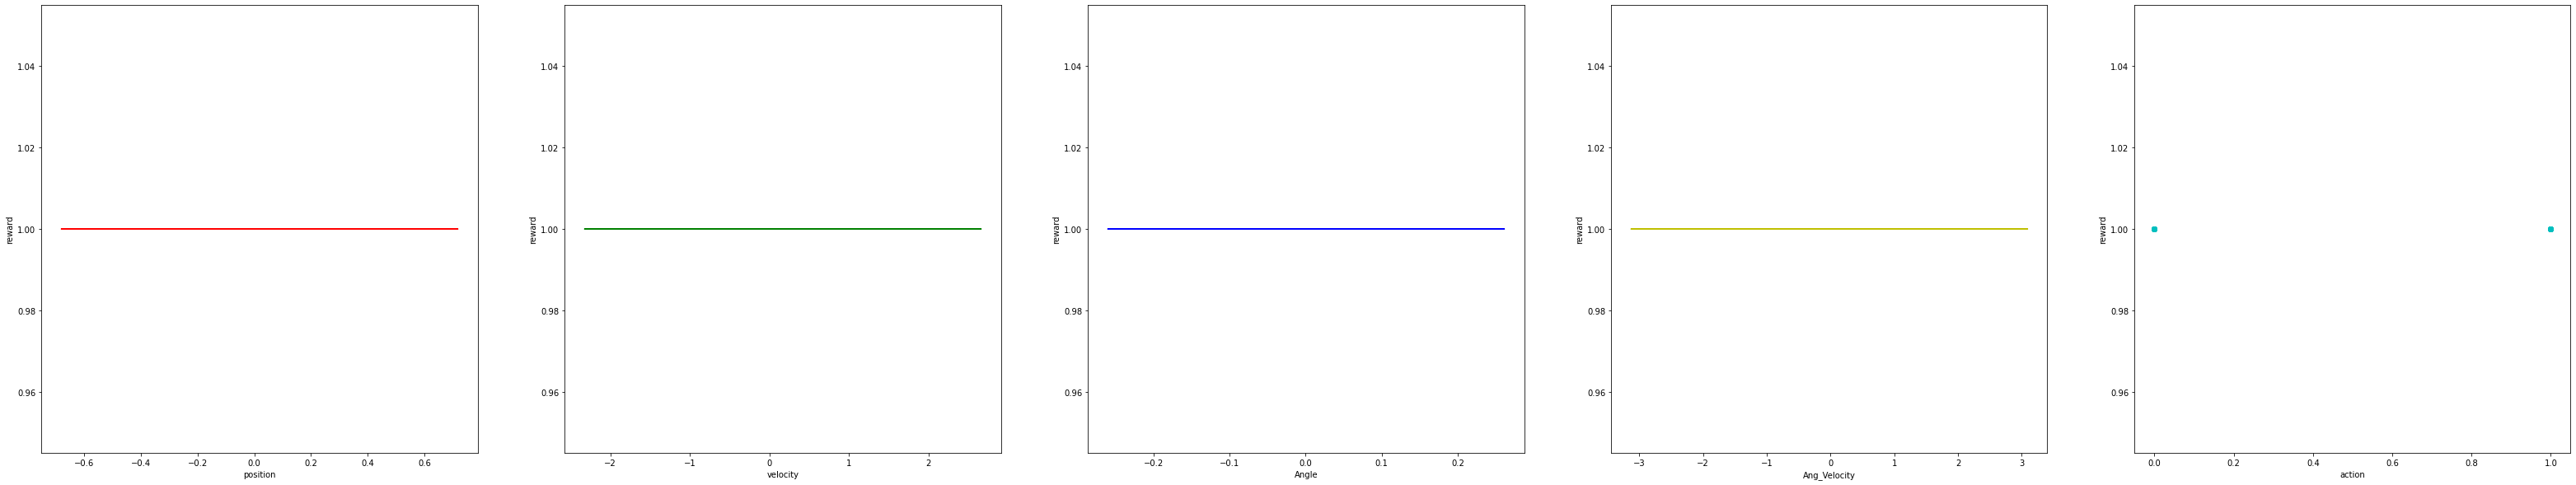

In [5]:
reward_plot(Environment)

# 3b)

## Policy Gradient Algorithm

### Deep Neural Model

In [ ]:
class Model(nn.Module):
    def __init__(self, input_layer,hidden_dimension,num_actions):
        super(Model, self).__init__()
        self.Net = nn.Sequential(nn.Linear(input_layer, hidden_dimension, bias=False),
                                   nn.ReLU(),
                                   nn.Linear(hidden_dimension,num_actions,bias=False),
                                   nn.Softmax(dim=-1))
        
    def forward(self,x):
        return self.Net(x)

### Agent Class for Creating, Training and  Optimizing our RL Agent

In [ ]:
class Agent:
    
    def __init__(self, lr, num_actions, batch_size, input_layer, gamma, iterations,rw_t_g = True, Adv_N = True):
        
        self.action_space = [i for i in range(num_actions)]
        self.batch_size = batch_size
        self.step_counter = 0
        self.lr = lr
        self.device = "cuda:0"
        self.Train_Net = Model(input_layer,256,num_actions).to(self.device)
        self.optimizer = optim.Adam(self.Train_Net.parameters(),lr=lr)
        self.reward_to_go = rw_t_g
        self.Advantage_Norm = Adv_N
        self.gamma = gamma
        self.iterations = iterations


    def policy(self,observation):
        
        probs = self.Train_Net(observation.to(self.device))
        m = Categorical(probs)
        action = m.sample()
        return action, m.log_prob(action)
    
    def get_torch_state(self,observation):
        
        state = np.array(observation)
        state = torch.from_numpy(state)
        state = state.type(torch.FloatTensor)
        state = state.unsqueeze(0)
        return state


    def optimize(self,Batch_Policy_History,Batch_Episode_Reward):
        
        if self.Advantage_Norm:
            baseline = 0.
            for eps in Batch_Episode_Reward:
                R = 0
                rewards = []
                for r in eps[::-1]:
                    R = r + self.gamma * R
                baseline += R
            baseline /= self.batch_size

        
        loss = 0.
        for i in range(len(Batch_Episode_Reward)):
            p = Batch_Policy_History[i]
            e = Batch_Episode_Reward[i]
            R = 0
            rewards = []
            for r in e[::-1]:
                R = r + self.gamma * R
                rewards.insert(0,R)
            
            p = torch.cat(p).type(torch.FloatTensor)
            rewards = torch.FloatTensor(rewards)
            
            if self.reward_to_go:
                if self.Advantage_Norm:
                    rewards =  rewards - baseline
                    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

                loss += torch.sum(torch.mul(p,rewards).mul(-1), -1)
            else:
                loss += torch.sum(torch.mul(p,rewards[0]).mul(-1), -1)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def train(self,env):
    
        rewards = []
        
        for i in range(self.iterations):   
            Batch_Episode_Reward = []
            Batch_Policy_History = []
            episode = 0
            while episode < self.batch_size:
                state = env.reset()
                state = self.get_torch_state(state)
                episode_rewards = []
                policy_history = []
                terminated = False
                while (not terminated):
                    action, policy_log = self.policy(state)
                    action = action.item()
                    observation,reward,terminated,_ = env.step(action)
                    state  =  self.get_torch_state(observation)
                    episode_rewards.append(reward)
                    policy_history.append(policy_log)
            
                Batch_Episode_Reward.append(episode_rewards)
                Batch_Policy_History.append(policy_history)
                episode+=1
            
            rewards.append(np.mean([np.sum(er) for er in Batch_Episode_Reward]))
            self.optimize(Batch_Policy_History,Batch_Episode_Reward)
        
            print('Total Reward for Iteration {} : {}'.format(i,rewards[-1]))   
        env.close()
    
        plt.plot(rewards,label='Mean Reward')
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.legend()
        plt.grid()
        plt.show()

        return rewards
    
    




# A Deep Neural Dense model with one hiddrn layer of size 256

## Reward to Go = True
## Advantage Norm = True

Total Reward for Iteration 0 : 22.8125
Total Reward for Iteration 1 : 30.84375
Total Reward for Iteration 2 : 51.21875
Total Reward for Iteration 3 : 58.75
Total Reward for Iteration 4 : 66.625
Total Reward for Iteration 5 : 70.0625
Total Reward for Iteration 6 : 80.125
Total Reward for Iteration 7 : 99.6875
Total Reward for Iteration 8 : 120.34375
Total Reward for Iteration 9 : 158.8125
Total Reward for Iteration 10 : 178.8125
Total Reward for Iteration 11 : 178.15625
Total Reward for Iteration 12 : 160.1875
Total Reward for Iteration 13 : 165.125
Total Reward for Iteration 14 : 173.40625
Total Reward for Iteration 15 : 180.5625
Total Reward for Iteration 16 : 182.0625
Total Reward for Iteration 17 : 193.375
Total Reward for Iteration 18 : 198.5
Total Reward for Iteration 19 : 199.125
Total Reward for Iteration 20 : 199.96875
Total Reward for Iteration 21 : 200.0
Total Reward for Iteration 22 : 200.0
Total Reward for Iteration 23 : 195.8125
Total Reward for Iteration 24 : 200.0
Total 

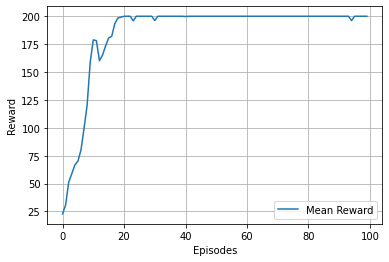

In [ ]:
env = gym.make("CartPole-v0")
agent = Agent(lr = 0.01, num_actions = env.action_space.n, batch_size = 32, input_layer = env.observation_space.shape[0], gamma = 0.9, iterations = 100,rw_t_g = True, Adv_N = True)
x1 = agent.train(env)

## Reward to Go = True
## Advantage Norm = False



Total Reward for Iteration 0 : 19.3125
Total Reward for Iteration 1 : 27.96875
Total Reward for Iteration 2 : 52.71875
Total Reward for Iteration 3 : 54.5
Total Reward for Iteration 4 : 64.15625
Total Reward for Iteration 5 : 65.46875
Total Reward for Iteration 6 : 97.0
Total Reward for Iteration 7 : 120.15625
Total Reward for Iteration 8 : 147.3125
Total Reward for Iteration 9 : 131.96875
Total Reward for Iteration 10 : 134.5
Total Reward for Iteration 11 : 150.53125
Total Reward for Iteration 12 : 144.75
Total Reward for Iteration 13 : 147.28125
Total Reward for Iteration 14 : 155.4375
Total Reward for Iteration 15 : 155.75
Total Reward for Iteration 16 : 160.875
Total Reward for Iteration 17 : 161.96875
Total Reward for Iteration 18 : 157.3125
Total Reward for Iteration 19 : 169.6875
Total Reward for Iteration 20 : 162.15625
Total Reward for Iteration 21 : 168.0
Total Reward for Iteration 22 : 188.25
Total Reward for Iteration 23 : 199.75
Total Reward for Iteration 24 : 198.25
Total

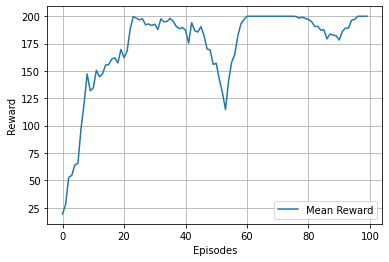

In [ ]:
env = gym.make("CartPole-v0")
agent = Agent(lr = 0.01, num_actions = env.action_space.n, batch_size = 32, input_layer = env.observation_space.shape[0], gamma = 0.9, iterations = 100,rw_t_g = True, Adv_N = False)
x2 = agent.train(env)

Reward to Go = False
Advantage Norm = False

Total Reward for Iteration 0 : 20.3125
Total Reward for Iteration 1 : 25.1875
Total Reward for Iteration 2 : 37.5
Total Reward for Iteration 3 : 36.28125
Total Reward for Iteration 4 : 42.5
Total Reward for Iteration 5 : 52.75
Total Reward for Iteration 6 : 48.875
Total Reward for Iteration 7 : 56.15625
Total Reward for Iteration 8 : 52.03125
Total Reward for Iteration 9 : 49.53125
Total Reward for Iteration 10 : 53.75
Total Reward for Iteration 11 : 58.625
Total Reward for Iteration 12 : 67.625
Total Reward for Iteration 13 : 59.28125
Total Reward for Iteration 14 : 72.40625
Total Reward for Iteration 15 : 53.875
Total Reward for Iteration 16 : 71.875
Total Reward for Iteration 17 : 69.28125
Total Reward for Iteration 18 : 63.9375
Total Reward for Iteration 19 : 83.46875
Total Reward for Iteration 20 : 74.90625
Total Reward for Iteration 21 : 78.3125
Total Reward for Iteration 22 : 65.71875
Total Reward for Iteration 23 : 78.0625
Total Reward for Iteration 24 : 68.15625
Total Reward f

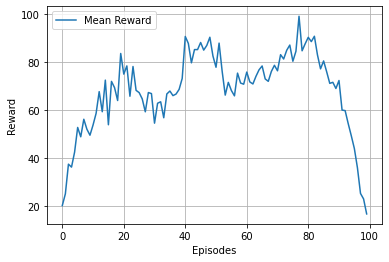

In [ ]:
env = gym.make("CartPole-v0")
agent = Agent(lr = 0.01, num_actions = env.action_space.n, batch_size = 32, input_layer = env.observation_space.shape[0], gamma = 0.9, iterations = 100,rw_t_g = False, Adv_N = False)
x3 = agent.train(env)

Reward to Go = False
Advantage Norm = True

Total Reward for Iteration 0 : 20.34375
Total Reward for Iteration 1 : 19.75
Total Reward for Iteration 2 : 20.21875
Total Reward for Iteration 3 : 23.625
Total Reward for Iteration 4 : 24.28125
Total Reward for Iteration 5 : 28.75
Total Reward for Iteration 6 : 31.46875
Total Reward for Iteration 7 : 36.6875
Total Reward for Iteration 8 : 38.84375
Total Reward for Iteration 9 : 32.6875
Total Reward for Iteration 10 : 32.5625
Total Reward for Iteration 11 : 28.59375
Total Reward for Iteration 12 : 32.75
Total Reward for Iteration 13 : 40.9375
Total Reward for Iteration 14 : 39.25
Total Reward for Iteration 15 : 38.78125
Total Reward for Iteration 16 : 36.96875
Total Reward for Iteration 17 : 41.46875
Total Reward for Iteration 18 : 41.8125
Total Reward for Iteration 19 : 40.4375
Total Reward for Iteration 20 : 33.8125
Total Reward for Iteration 21 : 30.125
Total Reward for Iteration 22 : 37.34375
Total Reward for Iteration 23 : 24.625
Total Reward for Iteration 24 : 28.4375
Total Rewar

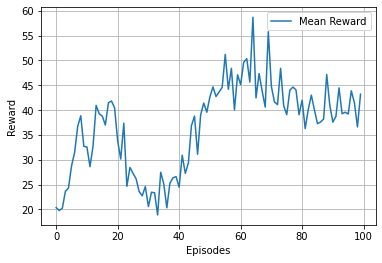

In [ ]:
env = gym.make("CartPole-v0")
agent = Agent(lr = 0.01, num_actions = env.action_space.n, batch_size = 32, input_layer = env.observation_space.shape[0], gamma = 0.9, iterations = 100,rw_t_g = False, Adv_N = True)
x4 = agent.train(env)

## Comparison of Learning Curves with and without Reward-to-go and Advantage Normalization

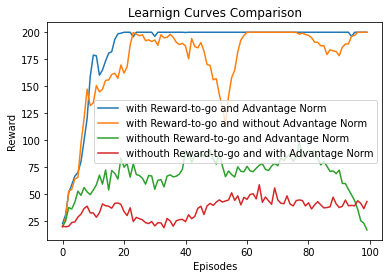

In [ ]:
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Learnign Curves Comparison")
plt.plot(x1,label = "with Reward-to-go and Advantage Norm")
plt.plot(x2,label = "with Reward-to-go and without Advantage Norm")
plt.plot(x3,label = "withouth Reward-to-go and Advantage Norm")
plt.plot(x4,label = "withouth Reward-to-go and with Advantage Norm")
plt.legend()
plt.show()

## By observing the learning curves, we can conclude that, when using reward to go 
## model converges and performs best with Advantage Norm slightly improving the rate of convergence

## On the other hand, without reward to go model doesn't converge with the one having Advantage norm performing slightly better

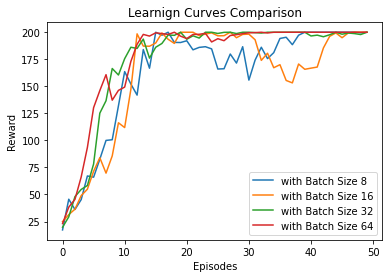

In [ ]:
rew = []
batch_size = [8,16,32,64]
for b in batch_size:
  env = gym.make("CartPole-v0")
  agent = Agent(lr = 0.01, num_actions = env.action_space.n, batch_size = b, input_layer = env.observation_space.shape[0], gamma = 0.9, iterations = 50,rw_t_g = True, Adv_N = True)
  x = agent.train(env)
  rew.append(x)

plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Learnign Curves Comparison")
plt.plot(rew[0],label = "with Batch Size 8")
plt.plot(rew[1],label = "with Batch Size 16")
plt.plot(rew[2],label = "with Batch Size 32")
plt.plot(rew[3],label = "with Batch Size 64")
plt.legend()
plt.show()



## From above model,we can infer that using larger Batch Size makes our model converge significantly faster